In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm, trange
import scipy.io

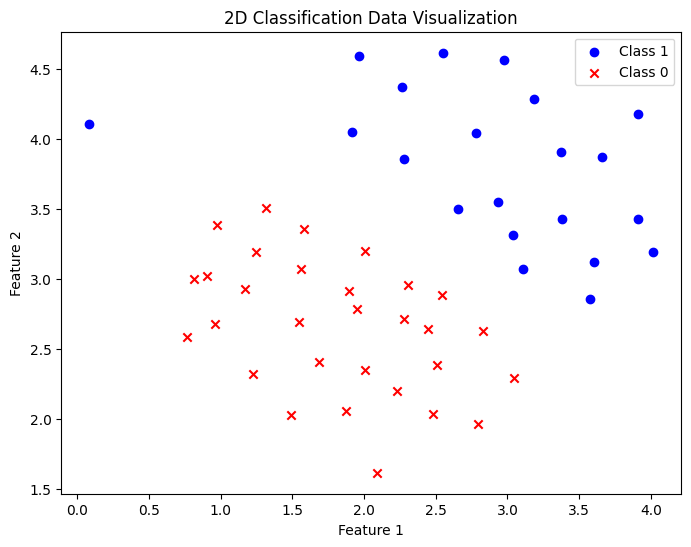

In [2]:
data = scipy.io.loadmat('../data/ex6data1.mat')
x = np.array(data['X'])
y = np.array(data['y']).astype(int)
y[y == 0] = -1
y = y.flatten()

# 可视化数据
plt.figure(figsize=(8, 6))
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], color='blue', marker='o', label='Class 1')
plt.scatter(x[y == -1][:, 0], x[y == -1][:, 1], color='red', marker='x', label='Class 0')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Classification Data Visualization')
plt.legend()
plt.show()

In [3]:
def SMO(x, y, ker, C, max_iter):
    '''
    SMO算法
    x，y：样本的值和类别
    ker：核函数，与线性回归中核函数的含义相同
    C：惩罚系数
    max_iter：最大迭代次数
    '''
    # 初始化参数
    m = x.shape[0]
    alpha = np.zeros(m)
    b = 0
        
    # 预先计算所有向量的两两内积，减少重复计算
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = ker(x[i], x[j])
    
    for l in trange(max_iter):
        # 开始迭代
        for i in range(m):
            # 有m个参数，每一轮迭代中依次更新
            # 固定参数alpha_i与另一个随机参数alpha_j，并且保证i与j不相等
            j = np.random.choice([l for l in range(m) if l != i])
            
            # 用-q/2p更新alpha_i的值
            eta = K[j, j] + K[i, i] - 2 * K[i, j] # 分母
            e_i = np.sum(y * alpha * K[:, i]) + b - y[i] # 分子
            e_j = np.sum(y * alpha * K[:, j]) + b - y[j]
            alpha_i = alpha[i] + y[i] * (e_j - e_i) / (eta + 1e-5) # 防止除以0
            zeta = alpha[i] * y[i] + alpha[j] * y[j]

            # 将alpha_i和对应的alpha_j保持在[0,C]区间
            # 0 <= (zeta - y_j * alpha_j) / y_i <= C
            if y[i] == y[j]:
                lower = max(0, zeta / y[i] - C)
                upper = min(C, zeta / y[i])
            else:
                lower = max(0, zeta / y[i])
                upper = min(C, zeta / y[i] + C)
            alpha_i = np.clip(alpha_i, lower, upper)
            alpha_j = (zeta - y[i] * alpha_i) / y[j]
            
            # 更新b
            b_i = b - e_i - y[i] * (alpha_i - alpha[i]) * K[i, i] - y[j] * (alpha_j - alpha[j]) * K[i, j]
            b_j = b - e_j - y[j] * (alpha_j - alpha[j]) * K[j, j] - y[i] * (alpha_i - alpha[i]) * K[i, j]
            if 0 < alpha_i < C:
                b = b_i
            elif 0 < alpha_j < C:
                b = b_j
            else:
                b = (b_i + b_j) / 2
            
            # 更新参数
            alpha[i], alpha[j] = alpha_i, alpha_j

    return alpha, b

In [4]:
C = 1e8
max_iter = 1000
np.random.seed(0)

alpha, b = SMO(x, y, ker=np.inner, C=C, max_iter=max_iter)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 495.85it/s]


In [5]:
sup_idx = alpha > 1e-5 # 支持向量的系数不为零
print('支持向量个数：', np.sum(sup_idx))
w = np.sum((alpha[sup_idx] * y[sup_idx]).reshape(-1, 1) * x[sup_idx], axis=0)
wx = x @ w.reshape(-1, 1)
b = -0.5 * (np.max(wx[y == -1]) + np.min(wx[y == 1]))
print('参数：', w, b)

支持向量个数： 5
参数： [3.35455785 9.37931367] -38.07103658597198


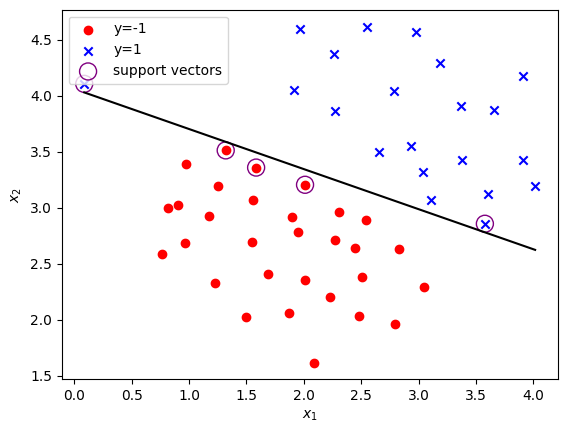

In [6]:
# 绘图
X = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
Y = -(w[0] * X + b) / (w[1] + 1e-5)
plt.figure()
plt.scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')
plt.plot(X, Y, color='black')

# 用圆圈标记出支持向量
plt.scatter(x[sup_idx, 0], x[sup_idx, 1], marker='o', color='none', 
    edgecolor='purple', s=150, label='support vectors')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()

In [7]:
from sklearn import svm
svc = svm.LinearSVC(C=1e8, loss='hinge', dual=True, max_iter=1000000)

svc.fit(x, y)
svc.score(x, y)

1.0

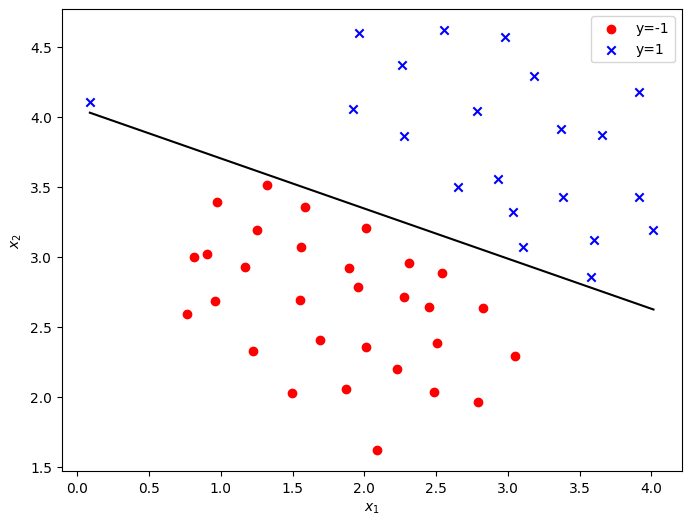

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

w = svc.coef_[0]
b = svc.intercept_[0]

def plot_svc_decision_boundary(w, b, xmin, xmax):
    X = np.linspace(xmin, xmax, 100)
    Y = -(w[0] * X + b) / (w[1] + 1e-5)
    plt.plot(X, Y, color='black')


xmin, xmax = np.min(x[:, 0]), np.max(x[:, 0])
ymin, ymax = np.min(x[:, 1]), np.max(x[:, 1])

plt.figure(figsize=(8, 6))
plt.scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')

# 绘制决策边界
plot_svc_decision_boundary(w, b, xmin, xmax)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()